## Capstone Project: Churn prediction for a telecom company and deployment with Flask  
### César Muro Cabral

In [15]:
import os
os.getcwd()

'g:\\Mi unidad\\Physics\\Books_articles_works\\Programming\\Individual_projects\\Machine learning notes and projects'

### Business understanding

In a telecom company that offers phone and internet services, and we have a problem: some of the customers are churning. They no longer are using our services and are going to a different provider. We would like to prevent that from happening, so we need develop a system for identifying these customers and offer them an incentive to stay. We want to target them with promotional messages and give them a discount. We also would like to understand why the model thinks our customers churn, and for that, we need to be able to interpret the model’s predictions.  
  
We have collected a dataset where we’ve recorded some information about our customers: what type of services they used, how much they paid, and how long they stayed with us. We also know who canceled their contracts and stopped using our services (churned). We will use this information as the target variable in the machine learning model and predict it using all other available information.

The plan for the project follows:  
  
1 First, we download the dataset and do some initial preparation: rename columns and change values inside columns to be consistent throughout the entire dataset.  
  
2 We perform exploration data analysis, we look at feature importance to identify which features are important in our data.  
  
4 We transform categorical variables into numeric variables. We construct a binary classification models with logistic regression and xgboost. We perform cross-validation to improve them. We evaluate on a test data and compare to select the best model.
  
5 We deploy the best model using Flask.  

###  Importing data

In [32]:
# We import the csv file from my GitHub
import pandas as pd
import seaborn as sns
url="https://raw.githubusercontent.com/cmuro27/Machine_Learning_Projects_and_Notes/main/datasets/WA_Fn-UseC_-Telco-Customer-Churn.csv"
df=pd.read_csv(url)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [3]:

df.head().T

,0,1,2,3,4
customerID,7590-VHVEG,5575-GNVDE,3668-QPYBK,7795-CFOCW,9237-HQITU
gender,Female,Male,Male,Male,Female
SeniorCitizen,0,0,0,0,0
Partner,Yes,No,No,No,No
Dependents,No,No,No,No,No
tenure,1,34,2,45,2
PhoneService,No,Yes,Yes,No,Yes
MultipleLines,No phone service,No,No,No phone service,No
InternetService,DSL,DSL,DSL,DSL,Fiber optic
OnlineSecurity,No,Yes,Yes,Yes,No



 The most interesting feature for us is Churn. As the target variable for our model, this is what we want to learn to predict. It takes two values: yes if the customer churned and no if the customer didn’t.  
  
  

### Processing and cleaning data

We observe that we have few numerical variables. Notice the type for TotalCharges. We would expect that this column to be numeric: it contains the total amount of money the client was charged, so it should be a number. Yet Pandas infers the type as “object.” The reason is that in some cases this column contains a space (“ ”) to represent a missing value. When coming across nonnumeric characters, Pandas has no other option but to declare the column “object.”  

We can force this column to be numeric by converting it to numbers using a special function in Pandas: to_numeric. By default, this function raises an exception when it sees nonnumeric data (such as spaces), but we can make it skip these cases by specifying the errors='coerce' option. This way Pandas will replace all nonnumeric values with a NaN (not a number).  

In [33]:
df.TotalCharges=pd.to_numeric(df.TotalCharges, errors="coerce")

We noticed that the column names don't follow the same naming convetion. Some of them start with a lower letter, others with capital letter, and there are also spaces in the values. Let's make it uniform by lowercasing everything and replacing spaces with underscores.

Moreover, some elements of the columns also contain spaces or parenthesis, we are going to replace them with underscores.

In [34]:
# Cleaning column names
df.columns = df.columns.str.lower().str.replace(" ","_")
string_columns = list(df.dtypes[df.dtypes=="object"].index)

# Cleaning categorical column
for col in string_columns:
    df[col]=df[col].str.lower().str.replace(' ','_').str.replace(')','').str.replace('(','')

C:\Users\cmuro\AppData\Local\Temp\ipykernel_32668\1152011411.py:7: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df[col]=df[col].str.lower().str.replace(' ','_').str.replace(')','').str.replace('(','')


Finally, we convert the churn category as a integer type, with 1 meaning churn.

In [35]:
# Convert churn category to binary
df.churn=(df.churn=="yes").astype(int)

In [36]:
df.head().T

,0,1,2,3,4
customerid,7590-vhveg,5575-gnvde,3668-qpybk,7795-cfocw,9237-hqitu
gender,female,male,male,male,female
seniorcitizen,0,0,0,0,0
partner,yes,no,no,no,no
dependents,no,no,no,no,no
tenure,1,34,2,45,2
phoneservice,no,yes,yes,no,yes
multiplelines,no_phone_service,no,no,no_phone_service,no
internetservice,dsl,dsl,dsl,dsl,fiber_optic
onlinesecurity,no,yes,yes,yes,no


### Exploration data analysis

Firts, we check for null values unique values:

In [38]:
print("List of null values per column: \n",df.isnull().sum())

List of null values per column: 
 customerid           0
gender               0
seniorcitizen        0
partner              0
dependents           0
tenure               0
phoneservice         0
multiplelines        0
internetservice      0
onlinesecurity       0
onlinebackup         0
deviceprotection     0
techsupport          0
streamingtv          0
streamingmovies      0
contract             0
paperlessbilling     0
paymentmethod        0
monthlycharges       0
totalcharges        11
churn                0
dtype: int64


We have only null values for totalcharges variable, we could fill with zeroes but we are going to use imputer in the machine learning process.

In [23]:
print("List of unique values per column: \n", df[string_columns].nunique().T)

List of unique values per column: 
 customerid          7043
gender                 2
partner                2
dependents             2
phoneservice           2
multiplelines          3
internetservice        3
onlinesecurity         3
onlinebackup           3
deviceprotection       3
techsupport            3
streamingtv            3
streamingmovies        3
contract               3
paperlessbilling       2
paymentmethod          4
totalcharges        6531
churn                  2
dtype: int64


We employ pandas_prolific to obtain an overview description such as distributions of each category, and correlation in the numeric data

In [37]:
from pandas_profiling import ProfileReport
pfr = ProfileReport(df)
pfr

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

For numerical values it seems we don't have outliers.

We can convert this report to html

In [16]:
pfr.to_file("Analys_telecom.html")

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

We can verify with the mutual information metric how the churn variable depends or it's influenced by the other categorical variables:

In [42]:

from sklearn.metrics import mutual_info_score
def calculate_mi(series):
    return mutual_info_score(series,df.churn)


df[string_columns].apply(calculate_mi).sort_values(ascending=False).to_frame(name="Mutual information with categorical variables")



,Mutual information with categorical variables
customerid,0.578599
churn,0.578599
contract,0.098453
onlinesecurity,0.064677
techsupport,0.063021
internetservice,0.055574
onlinebackup,0.046792
paymentmethod,0.044519
deviceprotection,0.043917
streamingmovies,0.032001


As we see, contract, onlinesecurity, and techsupport are among the most important features (figure 3.19). Indeed, we’ve already noted that contract and techsupport are quite informative. It’s also not surprising that gender is among the least important features, so we shouldn’t expect it to be useful for the model.

Let us create some visualization then for the three most relevant features

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns

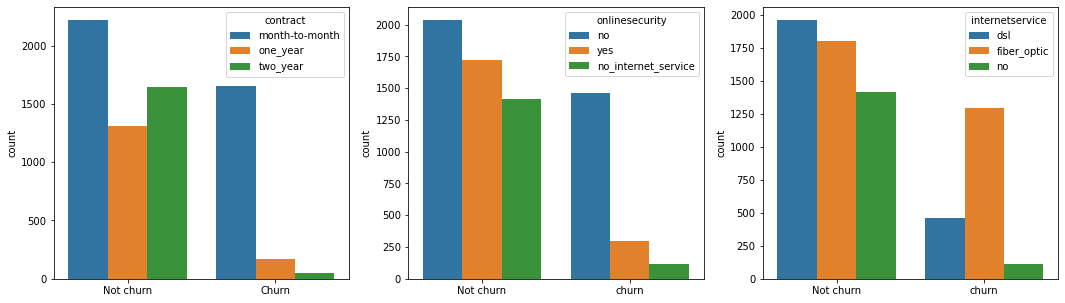

In [63]:
fig, axs = plt.subplots(ncols=3,figsize=(18,5))
sns.countplot(x='churn',hue='contract',data=df,ax=axs[0])
axs[0].set(xticklabels=(['Not churn','Churn']),xlabel=None)
sns.countplot(x="churn",hue="onlinesecurity",data=df,ax=axs[1])
axs[1].set(xticklabels=(['Not churn','churn']),xlabel=None)
sns.countplot(x="churn",hue="internetservice",data=df,ax=axs[2])
axs[2].set(xticklabels=(['Not churn','churn']),xlabel=None)
plt.show()

For numerical columns let us investigate the dependence with the churn variable using mutual information and the correlation coefficient.

In [48]:
numerical_columns = list(df.select_dtypes(include=['int64','float64']).columns)
# Using correlation coefficient

df[numerical_columns].corrwith(df.churn).sort_values(ascending=True).to_frame(name="Correlation coefficient with numerical variables")

,Correlation coefficient with numerical variables
tenure,-0.352229
totalcharges,-0.199484
seniorcitizen,0.150889
monthlycharges,0.193356


The correlation between tenure and churn is –0.35: it has a negative sign, so the longer customers stay, the less often they tend to churn. Monthlycharges has a positive coefficient of 0.19, which means that customers who pay more tend to leave more often.  totalcharges has a negative correlation, which makes sense: the longer people stay with the company, the more they have paid in total, so it’s less likely that they will leave.

### Machine learning model - Logistic regression with scikit-learn

Once we have process the data and making a exploratory data analysis, we proceed to create or models. As we mentioned, we are going to use logistic regression and xgboost classifier. We employ for this pipelines, where we treat separately numerical categorical data. For both, we will employ imputers for null values. For the numerical data, we also scaled the data. Then, we split the data in the training and test sets. We fit the model and evaluate.

As we have a binary classification problem, we use the area under roc curve to measure the performance of our model.

In [117]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, KFold, GridSearchCV  
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import  roc_auc_score, confusion_matrix
from sklearn.pipeline import Pipeline
import numpy as np

#Specify the independent variables and target variable from the dataframe
X=df.loc[:, ~df.columns.isin(['customerid', 'churn'])]
y=df.churn

#Lists of the numeric and categorical features
numeric_features=numerical_columns
categorical_features = df.select_dtypes(include=['object']).columns.tolist() 
categorical_features.remove('customerid')
#categorical_features=df.select_dtypes(include=['object']).columns.tolist().remove('customerid')

#Pipeline for preprocessing the numeric data by imputing and scaling. The strategy for the imputer will be the median
numeric_transformer=Pipeline(steps=[('imp_num',SimpleImputer(strategy='median')),('scaler',StandardScaler())])

#Pipeline for processing the categorical data, the strategy of the imputer will be the most_frequent
categorical_transformer=Pipeline(steps=[('imp_cat',SimpleImputer(strategy='most_frequent')),('onehot',OneHotEncoder(handle_unknown = 'ignore'))])

#Preprocessor for dealing the numeric and categorical features
preprocessor=ColumnTransformer(transformers=[('num', numeric_transformer, numeric_features),('cat', categorical_transformer, categorical_features)])


#Split the data, we use the stratify argument to ensure the proportions of the churn variable on both sets
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=40, stratify=y)

# Create the complete pipeline with the pre-process and the Logistic Regression model
pipeline_lr=Pipeline(steps=[('preprocess',preprocessor),('logreg',LogisticRegression())])


# We define the parameters for the GridSearch
kf = KFold(n_splits=4, random_state=42, shuffle=True)
params={'logreg__penalty':['l1','l2'],"logreg__solver": ['newton-cg','saga'],"logreg__C": [0.001,0.01,0.1,0.5,1,10],"logreg__max_iter":[50]}


# Initiate the grid search object
logreg_cv=GridSearchCV(estimator=pipeline_lr,scoring='roc_auc',param_grid=params,cv=kf)

We fit the model:

In [118]:
logreg_cv.fit(X_train,y_train)

c:\Users\cmuro\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\cmuro\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\cmuro\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\cmuro\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\cmuro\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\cmuro\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter 

GridSearchCV(cv=KFold(n_splits=4, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imp_num',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['seniorcitizen',
                                                                          'tenure',
                                                                          'monthlycharges',
                                                                          'totalcharges']),
    

In [119]:
#Print the tuned parameters and score
print('Tuned Logistic Regression parameters: {}'.format(logreg_cv.best_params_))
print("Tuned Logistic Regression roc_auc Score: {}".format(logreg_cv.best_score_))

Tuned Logistic Regression parameters: {'logreg__C': 10, 'logreg__max_iter': 50, 'logreg__penalty': 'l1', 'logreg__solver': 'saga'}
Tuned Logistic Regression roc_auc Score: 0.8457250931358938


We select the best estimator model

In [121]:
best_lr_model=logreg_cv.best_estimator_

to evaluate  it on the test data. We also plot the ROC curve

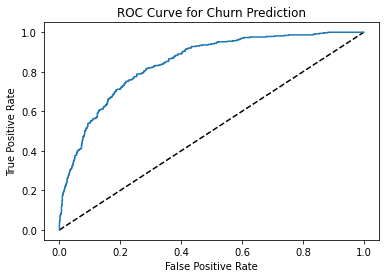

Tuned Logistic Regression roc_auc Score on test data 0.8435221783047869


In [131]:
pred_probs=best_lr_model.predict_proba(X_test)[:,1]
# Import roc_curve
from sklearn.metrics import roc_curve
# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, pred_probs)
plt.plot([0, 1], [0, 1], 'k--')
# Plot tpr against fpr
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Churn Prediction')
plt.show()
print("Tuned Logistic Regression roc_auc Score on test data",roc_auc_score(y_test,pred_probs))



## Machine learning model - XGBoost Classifier

It is said that the hottest machine learning library is XGBOOST

In [159]:
import xgboost as xgb
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import  roc_auc_score, confusion_matrix
from sklearn.pipeline import Pipeline
import numpy as np


#Specify the independent variables and target variable from the dataframe
X=df.loc[:, ~df.columns.isin(['churn'])]
y=df.churn

#Lists of the numeric and categorical features
numeric_features=numerical_columns
categorical_features = df.select_dtypes(include=['object']).columns.tolist() 
categorical_features.remove('customerid')
#categorical_features=df.select_dtypes(include=['object']).columns.tolist().remove('customerid')

#Pipeline for preprocessing the numeric data by imputing and scaling. The strategy for the imputer will be the median
numeric_transformer=Pipeline(steps=[('imp_num',SimpleImputer(strategy='median')),('scaler',StandardScaler())])

#Pipeline for processing the categorical data, the strategy of the imputer will be the most_frequent
categorical_transformer=Pipeline(steps=[('imp_cat',SimpleImputer(strategy='most_frequent')),('onehot',OneHotEncoder(handle_unknown = 'ignore'))])

#Preprocessor for dealing the numeric and categorical features
preprocessor=ColumnTransformer(transformers=[('num', numeric_transformer, numeric_features),('cat', categorical_transformer, categorical_features)])


#Split the data, we use the stratify argument to ensure the proportions of the churn variable on both sets
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=40, stratify=y)

# Create the complete pipeline with the pre-process and the xgb classifier indicating the objective and seed
pipeline_xgb=Pipeline(steps=[('preprocess',preprocessor),('xgb',xgb.XGBClassifier(objective='binary:logistic',seed=123))])

gbm_param_grid={'xgb__learning_rate':[0.01,0.1,0.5,0.9],'xgb__n_estimators':[150],'xgb__subsample':[0.3,0.5,0.9],'xgb__n_estimators':[50], 'xgb__max_depth': [2,5]}
kf= StratifiedKFold(n_splits=2,shuffle=True,random_state=40)


cv=GridSearchCV(estimator=pipeline_xgb,param_grid=gbm_param_grid,scoring='roc_auc',verbose=1,cv=kf)



In [160]:
# We fit the model
cv.fit(X_train,y_train)

Fitting 2 folds for each of 24 candidates, totalling 48 fits


GridSearchCV(cv=StratifiedKFold(n_splits=2, random_state=40, shuffle=True),
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imp_num',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['seniorcitizen',
                                                                          'tenure',
                                                                          'monthlycharges',
                                                                          'totalcharge

Let us see the performance of the best model generated

In [161]:
#Print the tuned parameters and score
print('Tuned XGB classifier parameters: {}'.format(cv.best_params_))
print("Tuned XGB classifier roc_auc Score: {}".format(cv.best_score_))

Tuned XGB classifier parameters: {'xgb__learning_rate': 0.1, 'xgb__max_depth': 2, 'xgb__n_estimators': 50, 'xgb__subsample': 0.3}
Tuned XGB classifier roc_auc Score: 0.8485856112755312


Nowe, we obtain the best model and investigate its performance in the test model

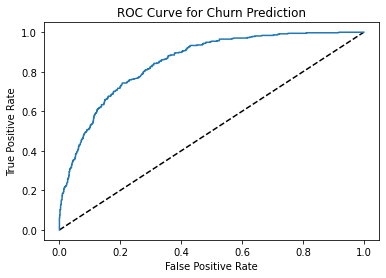

Tuned XGB classifier roc_auc Score on test data 0.849435531788473


In [162]:
# Select best estimator
xgb_best_model = cv.best_estimator_

# Predict on the test data
pred_probs = xgb_best_model.predict_proba(X_test)[:,1]
y_pred = xgb_best_model.predict(X_test)
#import the roc curve
from sklearn.metrics import roc_curve

# Genera curve values
fpr, tpr, thresholds = roc_curve(y_test, pred_probs)
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr,tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Churn Prediction')
plt.show()
print("Tuned XGB classifier roc_auc Score on test data",roc_auc_score(y_test,pred_probs))

In [163]:
from sklearn.metrics import classification_report, accuracy_score
# Calculate roc_auc_score
print("The area under curve is: ",roc_auc_score(y_test, pred_probs))

# Calculate the confusion matrix
print("The confusion matrix \n",confusion_matrix(y_test, y_pred))

# Calculate the classification report
print("The classification report \n",classification_report(y_test, y_pred))

The area under curve is:  0.849435531788473
The confusion matrix 
 [[942  93]
 [185 189]]
The classification report 
               precision    recall  f1-score   support

           0       0.84      0.91      0.87      1035
           1       0.67      0.51      0.58       374

    accuracy                           0.80      1409
   macro avg       0.75      0.71      0.72      1409
weighted avg       0.79      0.80      0.79      1409



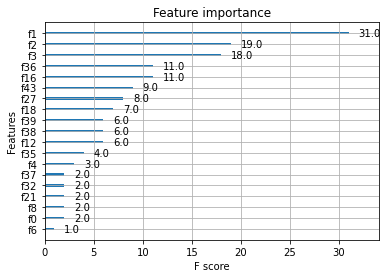

In [164]:
# Obtener el modelo xgboost de la tubería
xgb_model = xgb_best_model.named_steps['xgb']

# Obtener la importancia de características
xgb.plot_importance(xgb_model)
plt.show()

In [ ]:
 pd.Series(xgb_best_model.feature_importances_, index=X_train.columns)

We have obtained good models with logistic regression as well with XGB classification. Since XGB performs slightly better, we select it for deployment.

### Deployment with Flask

Now we need to put this model into production, so other services can use the model to make decisions based on the output of our model. We will package the model inside a web service, so other services can use it.

Let’s use this model to calculate the probability of churning for the following customer:

In [167]:
customer = { 'customerid': '8879-zkjof', 'gender': 'female', 'seniorcitizen': 0, 'partner': 'no', 'dependents': 'no', 'tenure': 41, 'phoneservice': 'yes', 'multiplelines': 'no',
'internetservice': 'dsl', 'onlinesecurity': 'yes', 'onlinebackup': 'no','deviceprotection': 'yes','techsupport': 'yes','streamingtv': 'yes','streamingmovies': 'yes',
'contract': 'one_year','paperlessbilling': 'yes','paymentmethod': 'bank_transfer_automatic','monthlycharges': 79.85,'totalcharges': 3320.75}

In [172]:
X_test_single=pd.DataFrame([customer])
pred_single = xgb_best_model.predict_proba(X_test_single)[:,1]
pred_single[0]

0.0924311

This means that this customer has a 9% probability of churning.

We can create a separate function for predicting the probability of churn for a single customer only. Let’s call this function predict_single:

In [179]:
def predict_single(customer,model):
    import pandas as pd
    x = pd.DataFrame([customer])
    y_pred = model.predict_proba(x)[:,1]
    return y_pred[0]

In [180]:
predict_single(customer,xgb_best_model)

0.0924311

Using Pickle to save and load the model  
  
To be able to use it outside of our notebook, we need to save it, and then later, another process can load and use it.  
  
Pickle is a serialization/deserialization module that’s already built into Python: Using it, we can save an arbitrary Python object (with a few exceptions) to a file. Once we have a file, we can load the model from there in a different process.   

In [181]:
# To save the model, we first import the Pickle module, and then use the dump function
import pickle
with open('churn-model.bin', 'wb') as f_out:
    pickle.dump(xgb_best_model, f_out)

The typical solution to deploy a model is putting it inside a web service — a small service (a microservice) that only takes care of scoring customers. So, we need to create a churn service — a service in Python that will serve the churn model. Given the features of a customer, it will respond with the probability of churn for this customer. For each customer, the campaign service will ask the churn service for the probability of churn, and if it’s high enough, then we send a promotional email.  
  
One of the most popular frameworks for creating web services in Python is Flask.

The easiest way to implement a web service in Python is to use Flask. It’s quite lightweight, requires little code to get started, and hides most of the complexity of dealing
with HTTP requests and responses.    

We have created apart (see file in the same repository) a script called churn_serving.py, which takes input data of a customer and returns the churn probability.

As a data exchange format, web services typically use JSON (Javascript Object Notation). It’s similar to the way we define dictionaries in Python:

To send data, we use POST requests, not GET: POST requests can include the data in the request, whereas GET cannot.  
Thus, to make it possible for the campaign service to get predictions from the churn service, we need to create a /predict route that accepts POST requests. The churn service will parse JSON data about a customer and respond in JSON as well

Now we know what we want to do, so let’s start modifying the churn_serving.py file.